Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


W0000 00:00:1741289778.963953 1215241 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


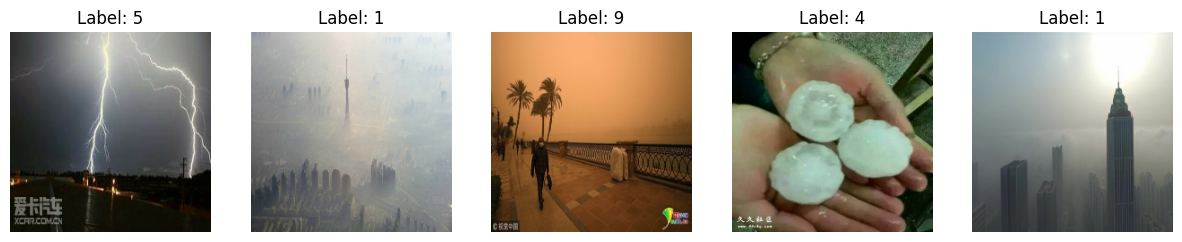

In [2]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

# Dataset/hyperparams
sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, val_dataset = dataset  

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

In [ ]:
import tensorflow as tf
import keras_tuner as kt
import pathlib
import matplotlib.pyplot as plt

num_classes = len(train_dataset.class_names)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
        
        # First convolutional block
        tf.keras.layers.Conv2D(
            filters=hp.Int("conv_1_filters", min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
            activation="relu",
            padding="same"
        ),
        tf.keras.layers.MaxPooling2D(),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(
            filters=hp.Int("conv_2_filters", min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice("conv_2_kernel", values=[3, 5]),
            activation="relu",
            padding="same"
        ),
        tf.keras.layers.MaxPooling2D(),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
            activation="relu"
        ),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    # Compile the model using a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Set up the Keras Tuner with Hyperband search
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="keras_tuner_dir",
    project_name="weather_cnn"
)

# Optional: early stopping callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[stop_early])

# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The best hyperparameters are:")
print(f"conv_1_filters: {best_hps.get('conv_1_filters')}")
print(f"conv_1_kernel: {best_hps.get('conv_1_kernel')}")
print(f"conv_2_filters: {best_hps.get('conv_2_filters')}")
print(f"conv_2_kernel: {best_hps.get('conv_2_kernel')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")


Trial 1 Complete [00h 04m 03s]
val_accuracy: 0.5590379238128662

Best val_accuracy So Far: 0.5590379238128662
Total elapsed time: 00h 04m 03s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filters
5                 |5                 |conv_1_kernel
128               |32                |conv_2_filters
5                 |3                 |conv_2_kernel
128               |192               |dense_units
0.01              |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2025-03-06 14:40:23.534971: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2025-03-06 14:40:26.571773: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.
2025-03-06 14:40:26.571867: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.


  1/172 ━━━━━━━━━━━━━━━━━━━━ 13:57 5s/step - accuracy: 0.0312 - loss: 66.5766

2025-03-06 14:40:27.661648: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2025-03-06 14:40:29.981427: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


 13/172 ━━━━━━━━━━━━━━━━━━━━ 8:34 3s/step - accuracy: 0.1210 - loss: 210433.5000

KeyboardInterrupt: 